---
title: "Nuclear norm regularization using Frank-Wolfe algorithm"
author: "Saikat Banerjee"
format:
  html: default
  ipynb: default
date: "2023-05-23"
file-modified: "2023-06-23"
abstract: "We implement the Frank-Wolfe algorithm for nuclear norm regularization. We compare it with an algorithm proposed by Duchi et al for projection on nuclear norm ball."

---

# About

David proposed a convex optimization algorithm for nuclear norm minimization of weighted matrix factorization. This is a pilot implementation of the algorithm, following his implementation [see here](https://github.com/daklab/npd_sumstats). I was not sure if the weighted matrix factorization was working. Therefore, I implemented the matrix completion to make sure that the algorithm is working to find the missing data.

In this proof-of-concept, we show that the NNWMF (we need a better acronym) indeed can find the missing data despite the noise in real data using an unit weight matrix.

Here are some references I used for the Frank-Wolfe algorithm:
  - [Martin Jaggi, "Revisiting Frank-Wolfe: Projection-Free Sparse Convex Optimization", PMLR 28(1):427-435, 2013](https://proceedings.mlr.press/v28/jaggi13.html)
  - [Martin Jaggi and Marek Sulovská, "A Simple Algorithm for Nuclear Norm Regularized Problems", ICML 2010](https://icml.cc/Conferences/2010/papers/196.pdf)
  - [Fabian Pedregosa, "Notes on the Frank-Wolfe Algorithm, Part I ", Personal Blog, 2018](https://fa.bianp.net/blog/2018/notes-on-the-frank-wolfe-algorithm-part-i/)
  - [Moritz Hardt, Lecture Notes on "Convex Optimization and Approximation", 2018](https://ee227c.github.io/code/lecture5.html)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

# Data

Summary statistics data for NPD is collected from PGC, OpenGWAS and GTEx. [See previous work](https://banskt.github.io/npd-notes/explore/preprocess_npd_gtex_pgc_ieu.html) for data cleaning and filtering. Our input is the Z-Score matrix for $N$ diseases and $P$ variants.

In [2]:
data_dir = "../data"
beta_df_filename   = f"{data_dir}/beta_df.pkl"
prec_df_filename   = f"{data_dir}/prec_df.pkl"
se_df_filename     = f"{data_dir}/se_df.pkl"
zscore_df_filename = f"{data_dir}/zscore_df.pkl"

'''
Data Frames for beta, precision, standard error and zscore.
'''

beta_df   = pd.read_pickle(beta_df_filename)
prec_df   = pd.read_pickle(prec_df_filename)
se_df     = pd.read_pickle(se_df_filename)
zscore_df = pd.read_pickle(zscore_df_filename)

trait_df = pd.read_csv(f"{data_dir}/trait_meta.csv")
phenotype_dict = trait_df.set_index('ID')['Broad'].to_dict()

In [3]:
#| code-fold: false

select_ids = beta_df.columns

X = np.array(zscore_df.replace(np.nan, 0)[select_ids]).T
colmeans = np.mean(X, axis = 0, keepdims = True)
Xcent = X - colmeans

labels = [phenotype_dict[x] for x in select_ids]
unique_labels = list(set(labels))

print (f"We have {Xcent.shape[0]} samples (phenotypes) and {Xcent.shape[1]} features (variants)")

We have 69 samples (phenotypes) and 10068 features (variants)


In [4]:
U, S, Vt = np.linalg.svd(Xcent, full_matrices = False)
print (f"Nuclear Norm of input matrix: {np.sum(S)}")

Nuclear Norm of input matrix: 7292.701186600059


We decompose the input matrix using SVD. 

$$
\mathbf{X} = \mathbf{U} \mathbf{S} \mathbf{V}^{\intercal}
$$

In @fig-input-eigenvalues we plot the eigenvalues of the input matrix.

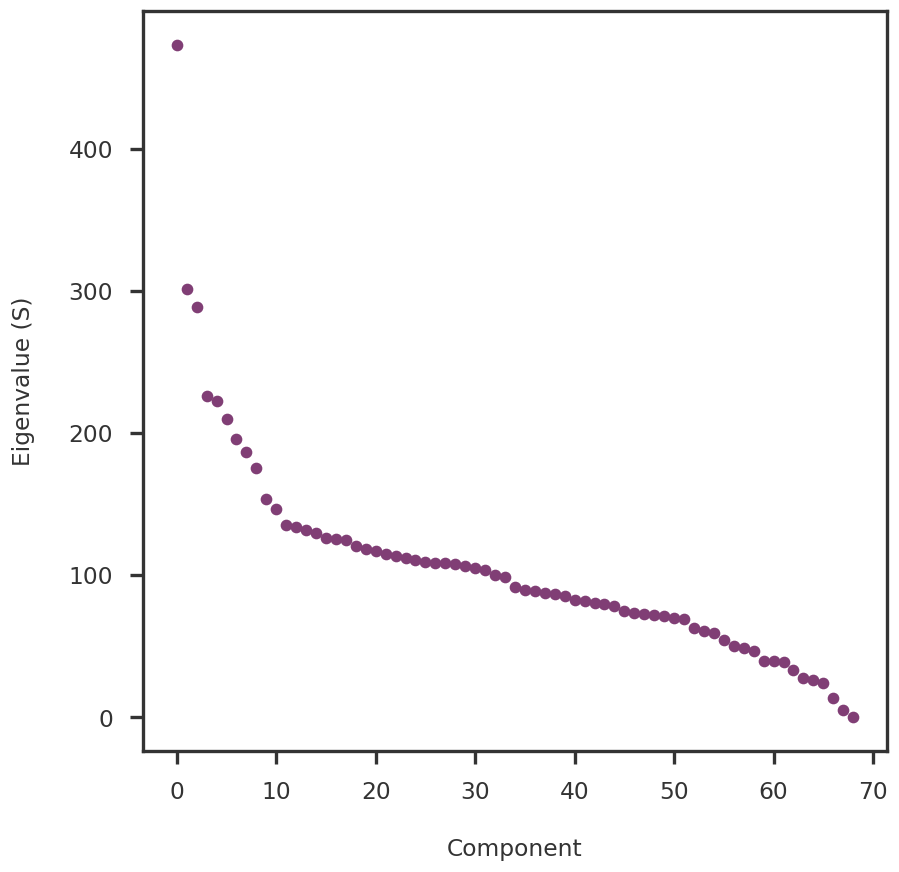

In [5]:
#| label: fig-input-eigenvalues
#| fig-cap: "Eigenvalues obtained using SVD of the input matrix"

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.arange(S.shape[0]), S)
ax1.set_xlabel("Component")
ax1.set_ylabel("Eigenvalue (S)")
plt.show()

# Weights

The idea is to use the precision matrix for the weights of the Z-scores. However, this is still under development. For now, we use equal weights for all Z-scores to compare NNWMF against classical SVD.

In [6]:
#| code-fold: false

# weight = np.array(prec_df[select_ids]).T * np.array(mean_se.loc[select_ids]) * np.array(mean_se.loc[select_ids])
# weight = np.array(prec_df[select_ids]).T
weight = np.ones(X.shape)

# Frank-Wolfe optimization

In the following, we implement the Frank-Wolfe optimization. The implementation currently uses a sequential value for the step size. 

To-do: Use line search for the step size.

In [7]:
#| code-fold: false

def f_objective(X, Y, mask = None):
    '''
    Objective function
    Y is observed, X is estimated
    '''
    Xmask = X if mask is None else X * mask
    return 0.5 * np.linalg.norm(Xmask - Y, 'fro')**2


def f_gradient(X, Y, mask = None):
    '''
    Gradient of the objective function.
    '''
    Xmask = X if mask is None else X * mask
    return Xmask - Y


def f_rmse(X, Y, mask = None):
    '''
    RMSE for masked CV
    '''
    Xmask = X if mask is None else X * mask
    return np.sqrt(np.mean(np.square(Xmask - Y)))


def linopt_oracle(grad, r = 1.0):
    '''
    Linear optimization oracle,
    where the feasible region is a nuclear norm ball for some r
    '''
    U1, V1_T = singular_vectors_power_method(grad, max_iter = 5)
    S = - r * U1 @ V1_T
    return S


def singular_vectors_randomized_method(X, max_iter = 10):
    u, s, vh = randomized_svd(X, n_components = 1, n_iter = max_iter,
                              power_iteration_normalizer = 'none',
                              random_state = 0)
    return u, vh


def singular_vectors_power_method(X, max_iter = 10):
    '''
    Power method.
        
        Computes approximate top left and right singular vector.
        
    Parameters:
    -----------
        X : array {m, n},
            input matrix
        max_iter : integer, optional
            number of steps
            
    Returns:
    --------
        u, v : (n, 1), (p, 1)
            two arrays representing approximate top left and right
            singular vectors.
    '''
    n, p = X.shape
    u = np.random.normal(0, 1, n)
    u /= np.linalg.norm(u)
    v = X.T.dot(u)
    v /= np.linalg.norm(v)
    for _ in range(max_iter):      
        u = X.dot(v)
        u /= np.linalg.norm(u)
        v = X.T.dot(u)
        v /= np.linalg.norm(v)       
    return u.reshape(-1, 1), v.reshape(1, -1)


def frank_wolfe_minimize_step(X, Y, r, istep, mask = None):
    G    = f_gradient(X, Y, mask = mask)
    S    = linopt_oracle(G, r)
    dg   = np.trace((X - S).T @ G)
    step = 2. / (2 + istep)
    #err  = old_X + S
    #step = np.sum((G * err) / np.square(err))
    #step = min(step, 1)
    Xnew = X + step * (S - X)
    return Xnew, G, dg, step


def frank_wolfe_minimize(Y, weight, r, X0 = None,
                         mask = None,
                         max_iter = 1000, tol = 1e-8,
                         return_all = True,
                         debug = False):
    
    # Step 0
    old_X = np.zeros_like(Y) if X0 is None else X0.copy()
    dg = np.inf

    if return_all:
        dg_list = [dg]
        fx_list = [f_objective(old_X, Y, mask)]
        
    # Steps 1, ..., max_iter
    for istep in range(max_iter):
        X, G, dg, step = \
            frank_wolfe_minimize_step(old_X, Y, r, istep, mask)

        if return_all:
            dg_list.append(dg)
            fx_list.append(f_objective(X, Y))
        
        if debug:
            if (istep % 10 == 0):
                print (f"Iteration {istep}. Step size {step:.3f}. Duality Gap {dg:g}")
        if np.abs(dg) <= tol:
            break
            
        old_X = X.copy()
        
    if return_all:
        return X, dg_list, fx_list
    else:
        return X


def is_monotonically_increasing(x):
    return all(x[i] >= x[i - 1] for i in range(1, x.shape[0]))


def frank_wolfe_cv_minimize(Y, weight, X0 = None,
                            r_seq = None,
                            max_iter = 1000, tol = 1e-8,
                            test_size = 0.33,
                            return_all = False,
                            debug_fw = False, debug = False):
    
    # Prepare CV masks
    n, p = Y.shape
    train_mask = np.ones(n * p)
    train_mask[:int(test_size * n * p)] = 0
    np.random.shuffle(train_mask)
    train_mask = train_mask.reshape(n, p)
    test_mask  = 1 - train_mask
    
    Ytrain = Y * train_mask
    Ytest  = Y * test_mask
    
    # Prepare rseq
    if r_seq is None:
        r_min = 1
        r_max = 4.0 * nuclear_norm(Y)
        nseq  = int(np.floor(np.log2(r_max)) + 1) + 1
        #r_seq = np.logspace(-ndec, nseq - 1, num = nseq + ndec, base = 2.0)
        r_seq = np.logspace(0, nseq - 1, num = nseq, base = 2.0)
    nseq = len(r_seq)
        
    train_err_dict = dict()
    test_err_dict = dict()
    old_X = None
    
    if debug:
        print (f"Perform CV at {nseq} positions.")
        print (r_seq)
    
    for iseq, r in enumerate(r_seq):
        X = frank_wolfe_minimize(Ytrain, weight, r, 
                                 max_iter = max_iter, X0 = old_X, tol = tol,
                                 mask = train_mask, return_all = False, debug = debug_fw) 
        train_err = f_rmse(X, Ytrain, train_mask)
        test_err  = f_rmse(X, Ytest, test_mask)
        if debug:
            print(f"CV sequence {iseq + 1}, r = {r}, training error = {train_err}, test_error = {test_err}")
        train_err_dict[r] = train_err
        test_err_dict[r] = test_err
        old_X = X.copy()
        
    return r_seq, train_err_dict, test_err_dict


def nuclear_norm(X):
    '''
    Nuclear norm of input matrix
    '''
    return np.sum(np.linalg.svd(X)[1])


# Code taken from https://gist.github.com/daien/1272551
def simplex_projection(s, alpha = 1.0):
    '''
    Compute the Euclidean projection on a positive simplex
    Solves the optimisation problem (using the algorithm from [1]):
    
        min_w 0.5 * || w - v ||_2^2 , s.t. \sum_i w_i = s, w_i >= 0
        
    Parameters
    ----------
    s: (n,) numpy array,
       n-dimensional vector to project
       
    alpha: int, optional, default: 1,
           radius of the simplex
           
    Returns
    -------
    w: (n,) numpy array,
       Euclidean projection of v on the simplex
       
    Notes
    -----
    The complexity of this algorithm is in O(n log(n)) as it involves sorting v.
    Better alternatives exist for high-dimensional sparse vectors (cf. [1])
    However, this implementation still easily scales to millions of dimensions.
    
    References
    ----------
    [1] Efficient Projections onto the .1-Ball for Learning in High Dimensions
        John Duchi, Shai Shalev-Shwartz, Yoram Singer, and Tushar Chandra.
        International Conference on Machine Learning (ICML 2008)
        http://www.cs.berkeley.edu/~jduchi/projects/DuchiSiShCh08.pdf

    '''
    n, = s.shape
    # check if we are already on the simplex
    if np.sum(s) == alpha and np.alltrue(s >= 0):
        # best projection: itself!
        return s
    
    # get the array of cumulative sums of a sorted (decreasing) copy of v
    u = np.sort(s)[::-1]
    cssv = np.cumsum(u)
    # get the number of > 0 components of the optimal solution
    rho = np.nonzero(u * np.arange(1, n + 1) > (cssv - alpha))[0][-1]
    # compute the Lagrange multiplier associated to the simplex constraint
    theta = float(cssv[rho] - alpha) / (rho + 1.0)
    # compute the projection by thresholding v using theta
    w = (s - theta).clip(min=0)
    return w

def nuclear_projection(X, r = 1.0):
    '''
    Projection onto nuclear norm ball.
    '''
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    sproj = simplex_projection(s, alpha = r)
    return U @ np.diag(sproj) @ Vt

# Numerical Experiment 1:  Projection of input data on nuclear norm ball with rank <= 1000

In our first experiment, we project the input data on a nuclear norm ball with rank $r \le 1000$. 

## Simplex projection

Project the input matrix on nuclear norm ball, using an algorithm proposed by Duchi et. al. in "Efficient projections onto the l1-ball for learning in high dimensions", [Proc. 25th ICML, pages 272–279. ACM, 2008](https://doi.org/10.1145/1390156.1390191). This is computationally expensive but will help to compare the results from Frank-Wolfe algorithm.

In [8]:
Xproj = nuclear_projection(Xcent, r = 1000)
Xproj = Xproj - np.mean(Xproj, axis = 0, keepdims = True)
U, S, Vt = np.linalg.svd(Xproj)
print(f"Nuclear norm of projected input matrix is {np.sum(S)}")

Nuclear norm of projected input matrix is 1000.0000000000019


## Frank-Wolfe

In [9]:
X_opt, gs, fx = frank_wolfe_minimize(Xcent, weight, 1000.0, max_iter = 500, debug = False)

In @fig-fw-descent, we show the progress of the optimization. On the left hand side, we show the duality gap and on the right hand side, we show the objective function.

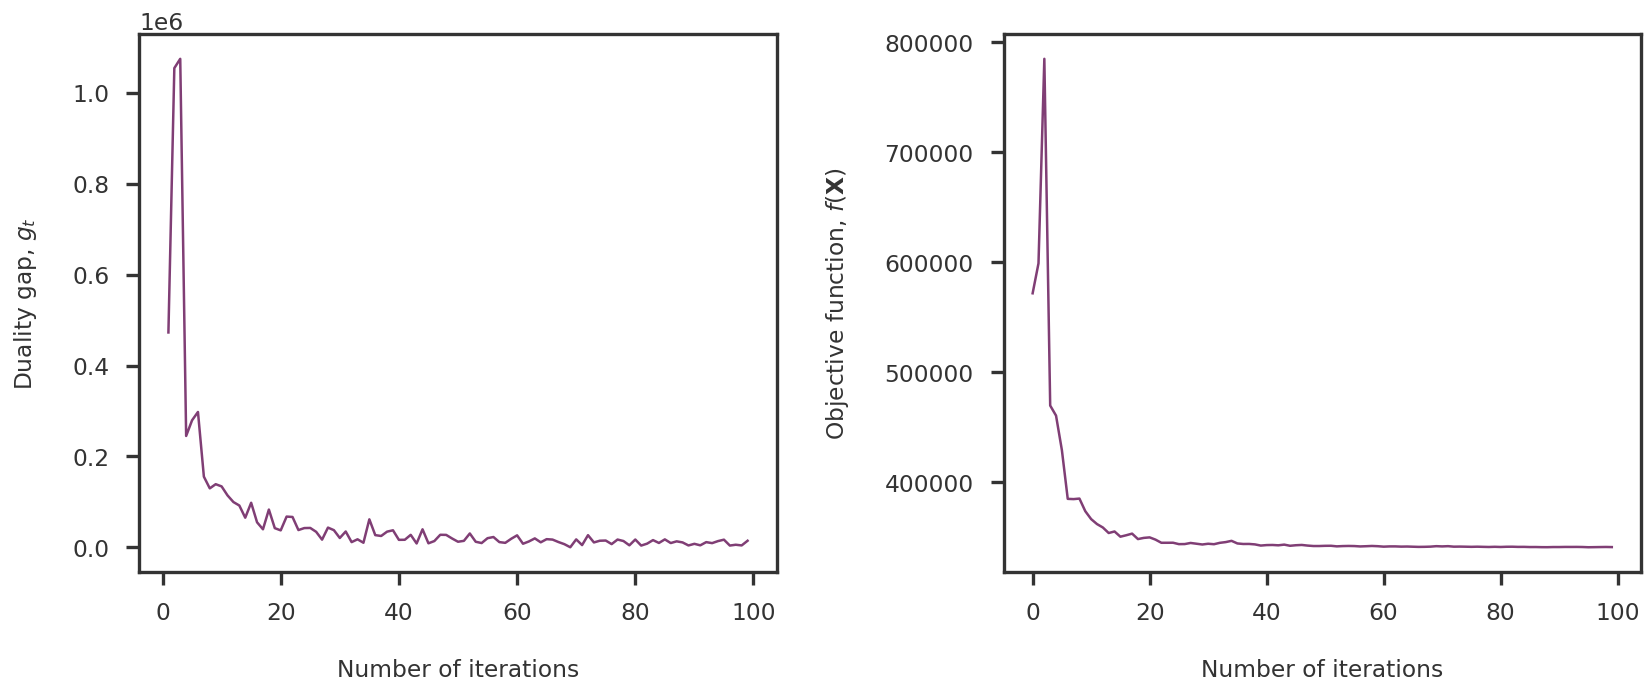

In [10]:
#| label: fig-fw-descent
#| fig-cap: "Frank-Wolfe optimization statistic"

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

kp = 100
ax1.plot(np.arange(kp), gs[:kp])
ax2.plot(np.arange(kp), fx[:kp])

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

In [11]:
X_opt_cent = X_opt - np.mean(X_opt, axis = 0, keepdims = True)
U_fw, S_fw, Vt_fw = np.linalg.svd(X_opt_cent)

In @fig-input-proj-eigenvalues, we compare the singular values of the output signal from the nuclear norm projection and the Frank-Wolfe algorithm. This gives us confidence with the implementation.

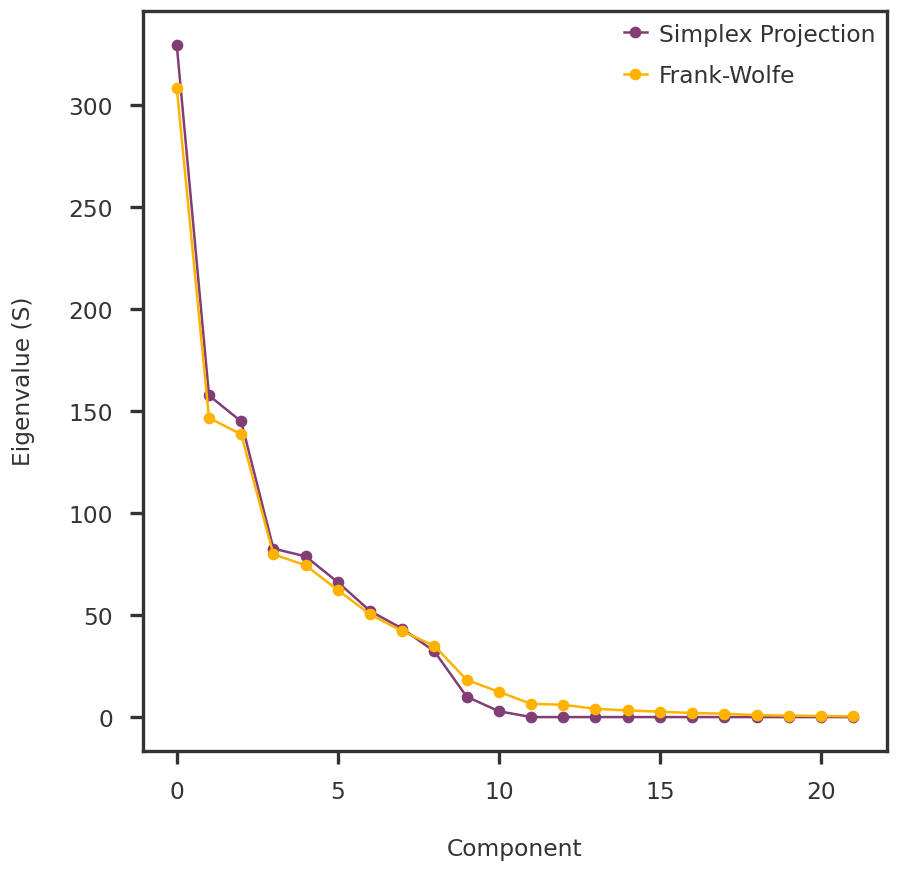

In [12]:
#| label: fig-input-proj-eigenvalues
#| fig-cap: "Eigenvalues obtained using SVD of the projected input matrix"

fig = plt.figure()
ax1 = fig.add_subplot(111)

kp = 22
ax1.plot(np.arange(kp), S[:kp], 'o-', label = 'Simplex Projection')
ax1.plot(np.arange(kp), S_fw[:kp], 'o-', label = 'Frank-Wolfe')

ax1.legend()
ax1.set_xlabel("Component")
ax1.set_ylabel("Eigenvalue (S)")
plt.show()

# Experiment 2: Matrix completion

In this numerical experiment, we plant missing onto the input matrix and then obtain the nuclear norm projection, which can approximate the missing data. We compare the singular values obtained from the simplex projection and Frank-Wolfe method in @fig-input-missing-proj-eigenvalues

In [13]:
# Generate missing data

n, p = Xcent.shape
test_size = 0.33
O = np.ones(n * p)
ntest = int(test_size * n * p)
O[:ntest] = 0
np.random.shuffle(O)
O = O.reshape(n, p)

Xmiss = X * O

In [14]:
Xmiss_proj = nuclear_projection(Xmiss, r = 1000)
Um, Sm, Vtm = np.linalg.svd(Xmiss_proj)
print(f"Nuclear norm of projected input matrix is {np.sum(Sm)}")

proj_err = np.sqrt(np.mean(np.square( (X * (1 - O)) - (Xmiss_proj * (1 - O)) )))
print (f"RMSE on test data = {proj_err}")

Nuclear norm of projected input matrix is 1000.0000000000011
RMSE on test data = 0.6567133713958933


In [15]:
Xmiss_opt, gs_mc, fx_mc = frank_wolfe_minimize(Xmiss, weight, 1000.0, max_iter = 100, debug = False, mask = O)

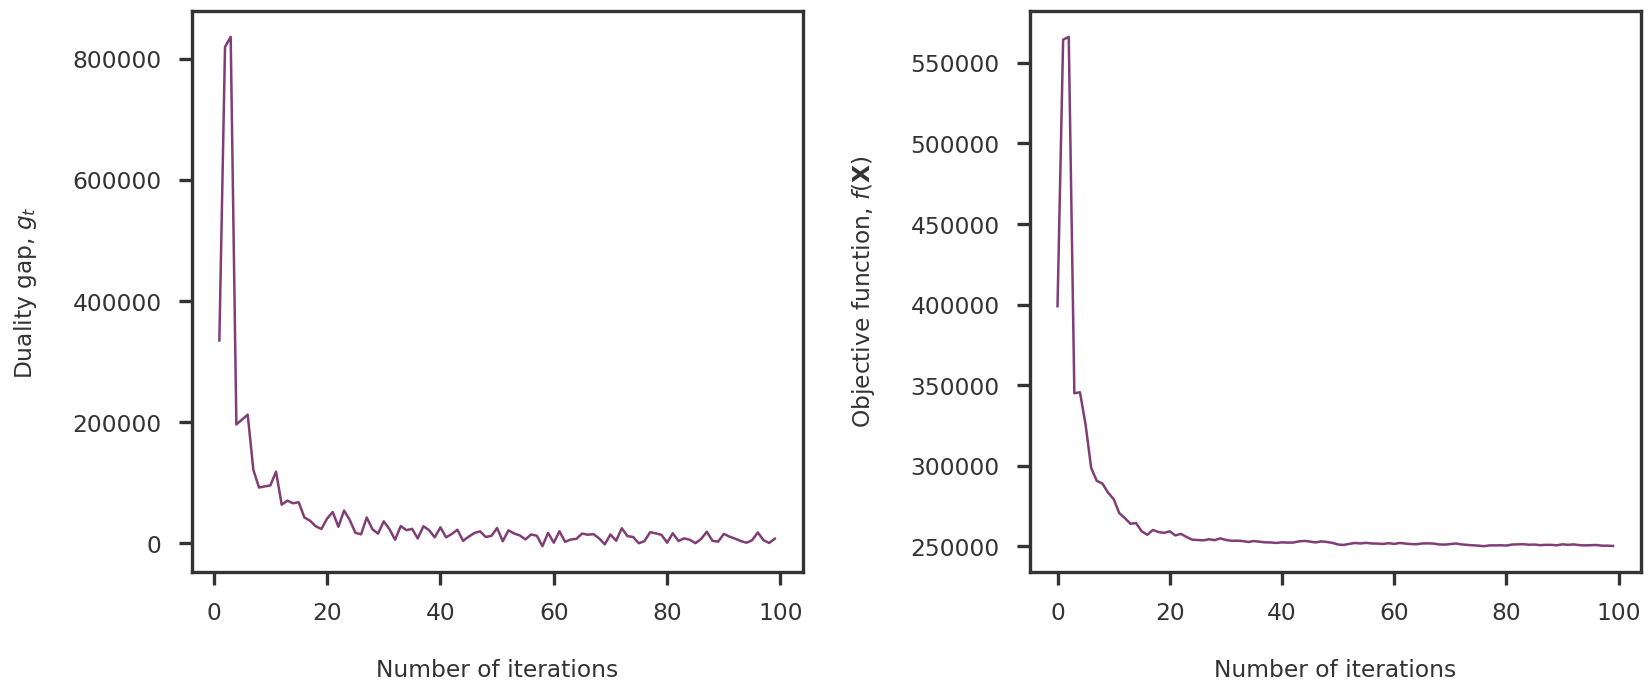

In [16]:
#| label: fig-fw-descent-missing
#| fig-cap: "Frank-Wolfe optimization statistic for missing data"

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

kp = 100
ax1.plot(np.arange(kp), gs_mc[:kp])
ax2.plot(np.arange(kp), fx_mc[:kp])

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

In [17]:
Xmiss_opt_cent = Xmiss_opt - np.mean(Xmiss_opt, axis = 0, keepdims = True)
Um_fw, Sm_fw, Vtm_fw = np.linalg.svd(Xmiss_opt_cent)

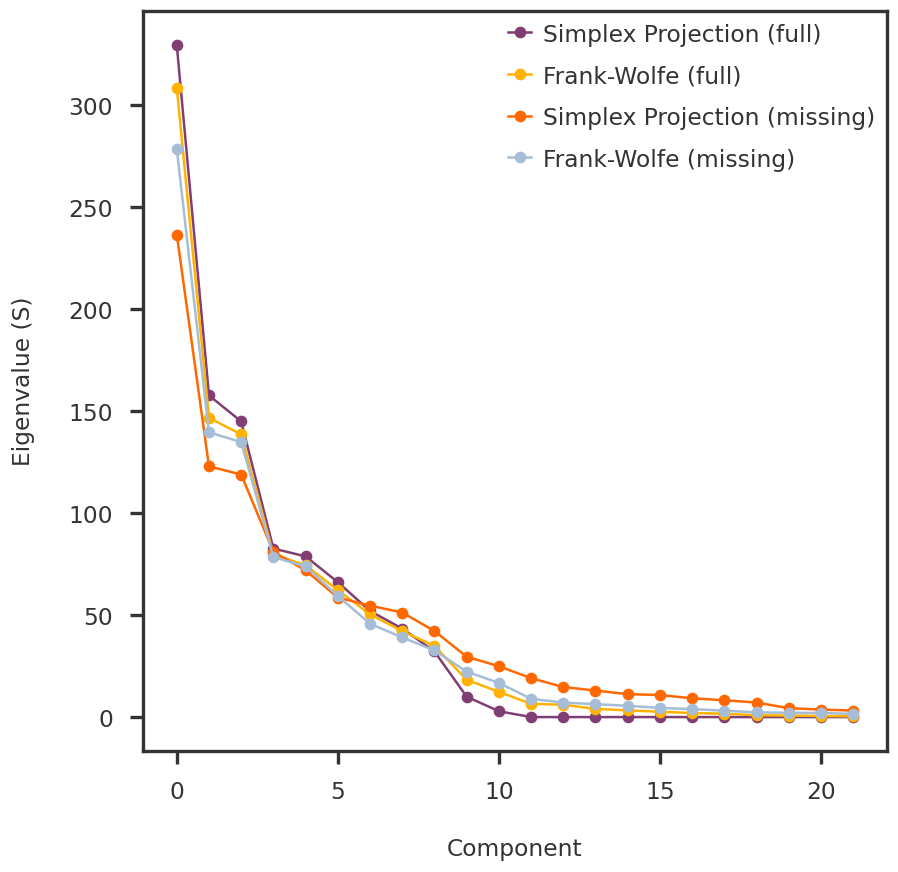

In [18]:
#| label: fig-input-missing-proj-eigenvalues
#| fig-cap: "Eigenvalues obtained using SVD of the projected input matrix with missing data"

fig = plt.figure()
ax1 = fig.add_subplot(111)

kp = 22
ax1.plot(np.arange(kp), S[:kp], 'o-', label = 'Simplex Projection (full)')
ax1.plot(np.arange(kp), S_fw[:kp], 'o-', label = 'Frank-Wolfe (full)')
ax1.plot(np.arange(kp), Sm[:kp], 'o-', label = 'Simplex Projection (missing)')
ax1.plot(np.arange(kp), Sm_fw[:kp], 'o-', label = 'Frank-Wolfe (missing)')

ax1.legend()
ax1.set_xlabel("Component")
ax1.set_ylabel("Eigenvalue (S)")
plt.show()

# Experiment 3: Cross-Validation to find the best nuclear norm

Here, we only use the Frank-Wolfe method. 

In [37]:
nseq = 10
r_seq = np.hstack((np.logspace(3, 12, num = nseq, base = 2.0), np.linspace(5000, 8000, 4)))
print (r_seq)

[   8.   16.   32.   64.  128.  256.  512. 1024. 2048. 4096. 5000. 6000.
 7000. 8000.]


In [40]:
#! code-fold: false

r_seq, train_error, test_error = frank_wolfe_cv_minimize(Xcent, weight, r_seq = r_seq, debug = True, max_iter = 100, tol = 1e-3)

Perform CV at 14 positions.
[   8.   16.   32.   64.  128.  256.  512. 1024. 2048. 4096. 5000. 6000.
 7000. 8000.]
CV sequence 1, r = 8.0, training error = 1.0445314519131719, test_error = 0.7379283863527464
CV sequence 2, r = 16.0, training error = 1.041037978310444, test_error = 0.7360553648577052
CV sequence 3, r = 32.0, training error = 1.0342448061985816, test_error = 0.7323992229046496
CV sequence 4, r = 64.0, training error = 1.0212031961118844, test_error = 0.7252923894633748
CV sequence 5, r = 128.0, training error = 0.9980512728715728, test_error = 0.7126499267407608
CV sequence 6, r = 256.0, training error = 0.9592552598273123, test_error = 0.6929325616806638
CV sequence 7, r = 512.0, training error = 0.8958869142145245, test_error = 0.6650417778754745
CV sequence 8, r = 1024.0, training error = 0.7931029154998555, test_error = 0.6294795062102471
CV sequence 9, r = 2048.0, training error = 0.6284386790184624, test_error = 0.5984243261174017
CV sequence 10, r = 4096.0, traini

In @fig-cv-training-error, we show the training error for different values of the regularization parameter. Finally, we run the Frank-Wolfe optimization on the full data at the optimum value of the regularization parameter.

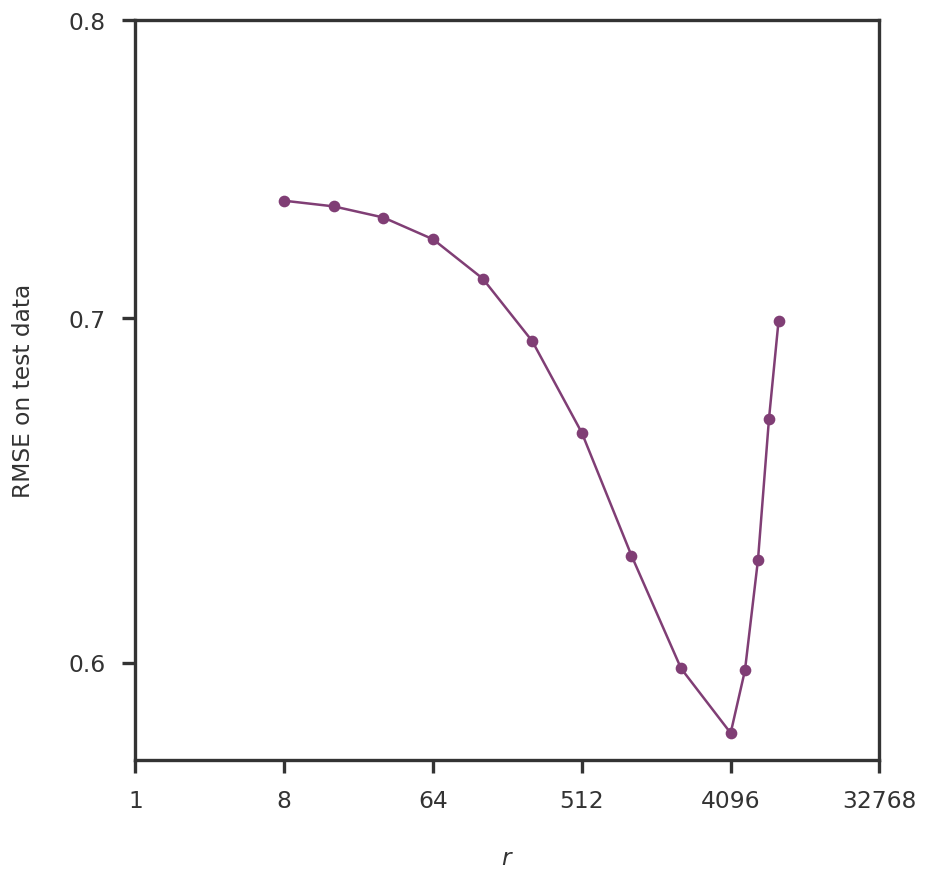

In [41]:
#| label: fig-cv-training-error
#| fig-cap: "CV training error"

fig = plt.figure()
ax1 = fig.add_subplot(111)

n_cv = len(train_error)
ax1.plot(np.log2(r_seq), np.log10(list(test_error.values())), 'o-')
ax1.set_xlabel(r"$r$")
ax1.set_ylabel("RMSE on test data")
xtickmarks = [1, 8, 64, 512, 4096, 32768]
ytickmarks = [0.6, 0.7, 0.8]
mpl_utils.set_xticks(ax1, kmax = 10, scale = 'log2', spacing = 'log2', tickmarks = xtickmarks)
mpl_utils.set_yticks(ax1, kmin = 4, kmax = 6, scale = 'log10', spacing = 'log10', 
                     tickmarks = ytickmarks, fmt = "{:.1f}")
plt.show()

In [42]:
#| code-fold: false

r_opt = min(train_error, key=train_error.get)
X_cvopt, dg_cvopt, fx_cvopt = frank_wolfe_minimize(Xcent, weight, r_opt)

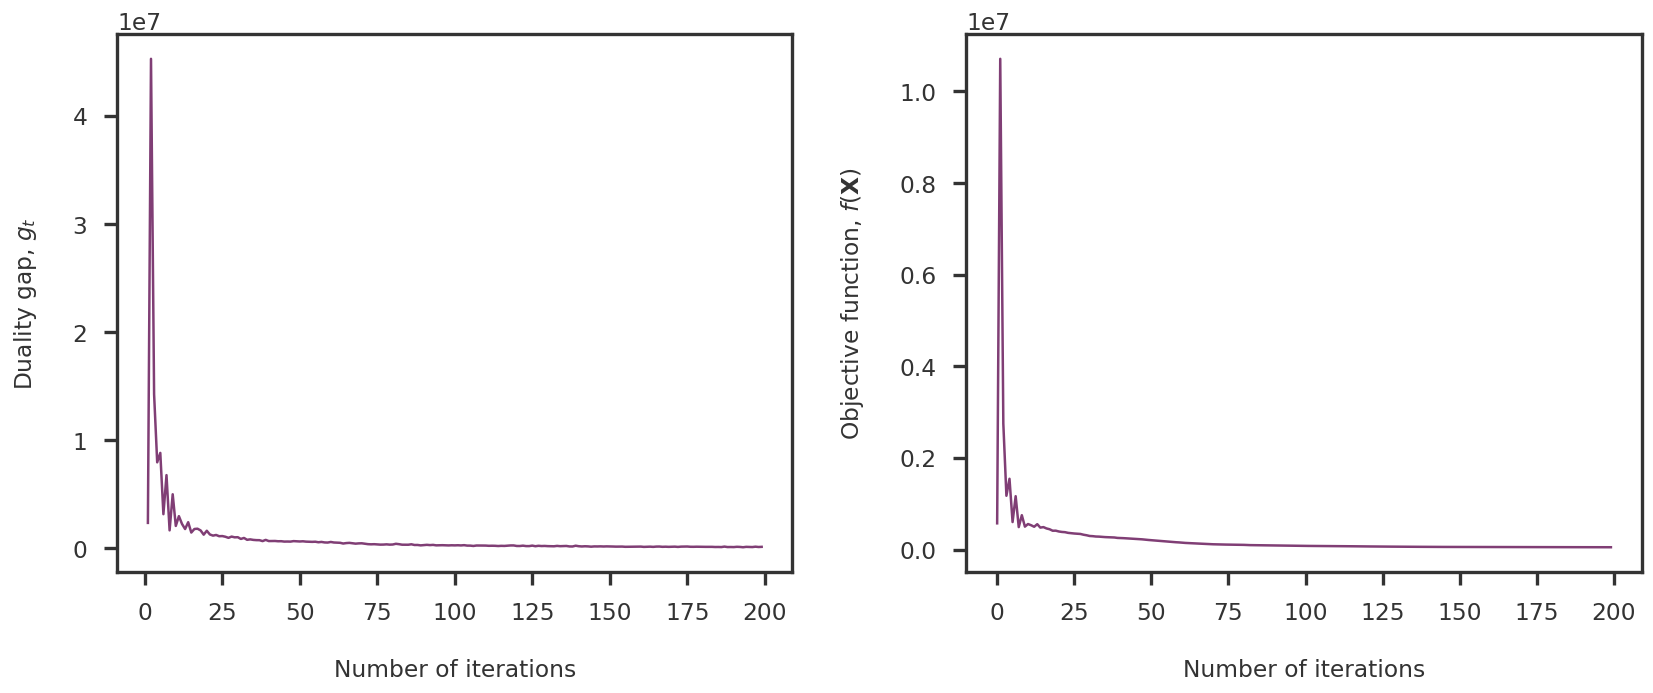

In [50]:
#| label: fig-fw-descent-cvopt
#| fig-cap: "Frank-Wolfe minimization at optimum regularization parameter"

fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

kp = 200
ax1.plot(np.arange(kp), dg_cvopt[:kp])
ax2.plot(np.arange(kp), fx_cvopt[:kp])

ax1.set_xlabel("Number of iterations")
ax2.set_xlabel("Number of iterations")
ax1.set_ylabel(r"Duality gap, $g_t$")
ax2.set_ylabel(r"Objective function, $f(\mathbf{X})$")
fig.tight_layout(w_pad = 2.0)
plt.show()

## Compare the principal components of the recovered matrix

In [44]:
U_input, S_input, Vt_input = np.linalg.svd(Xcent, full_matrices=False)
pca_input = U_input @ np.diag(S_input)

In [45]:
X_cvopt_cent = X_cvopt - np.mean(X_cvopt, axis = 0, keepdims = True)
U_cvopt, S_cvopt, Vt_cvopt = np.linalg.svd(X_cvopt_cent, full_matrices = False)
pca_cvopt = U_cvopt @ np.diag(S_cvopt)

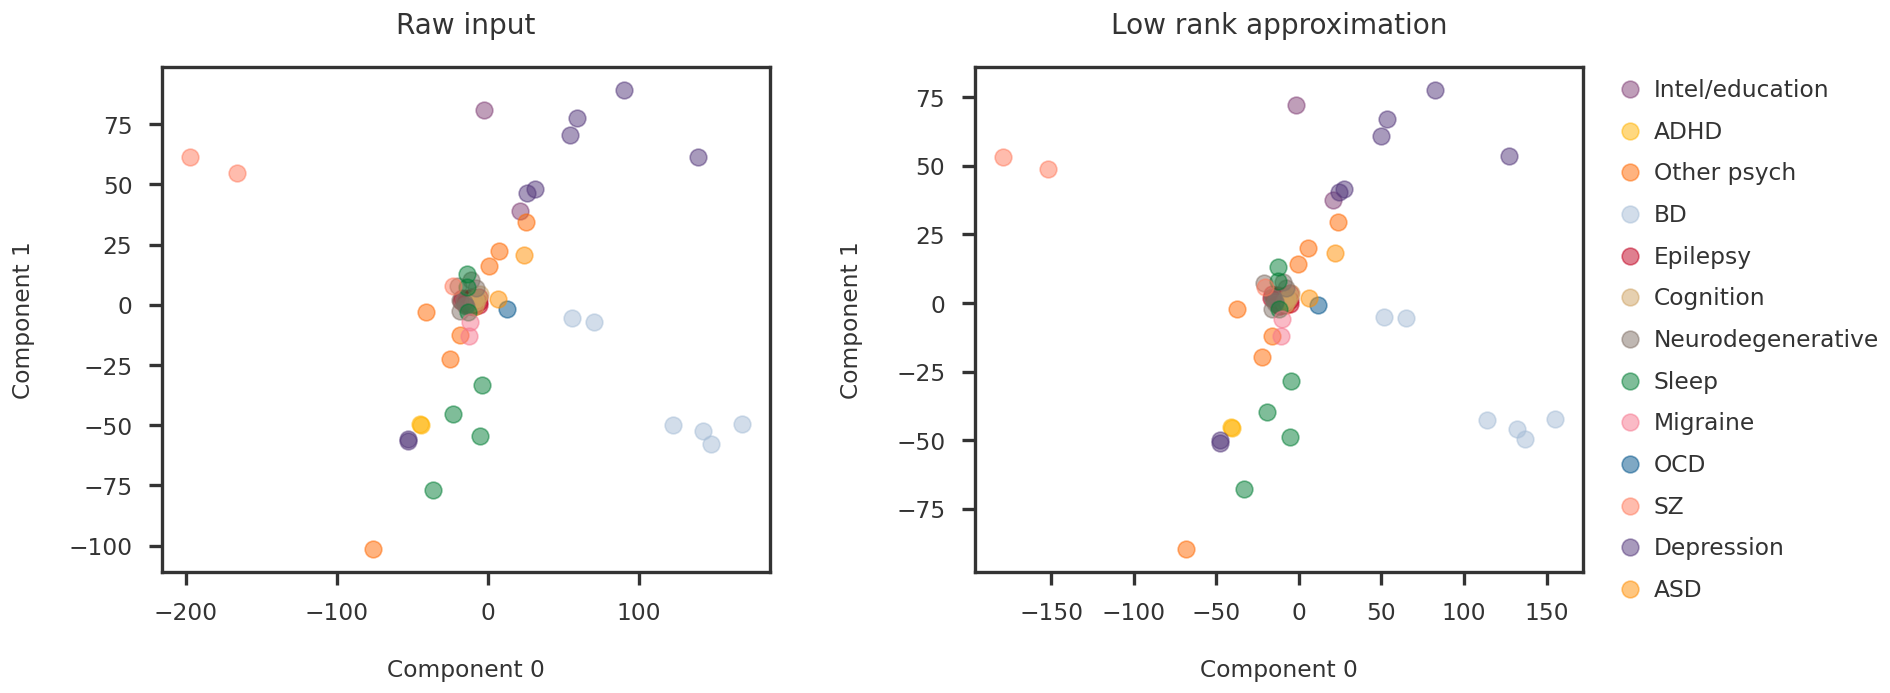

In [47]:
#| label: fig-pca-low-rank-approx
#| fig-cap: "Comparison of the first two principal components of input matrix and low rank approximation"

idx1 = 0
idx2 = 1

svd_pc1 = pca_input[:, idx1]
svd_pc2 = pca_input[:, idx2]
wmf_pc1 = pca_cvopt[:, idx1]
wmf_pc2 = pca_cvopt[:, idx2]

fig = plt.figure(figsize = (16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for label in unique_labels:
    idx = np.array([i for i, x in enumerate(labels) if x == label])
    ax1.scatter(svd_pc1[idx], svd_pc2[idx], s = 100, alpha = 0.5, label = label)
    ax2.scatter(wmf_pc1[idx], wmf_pc2[idx], s = 100, alpha = 0.5, label = label)
    
ax2.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
ax1.set_xlabel(f"Component {idx1}")
ax1.set_ylabel(f"Component {idx2}")
ax2.set_xlabel(f"Component {idx1}")
ax2.set_ylabel(f"Component {idx2}")
ax1.set_title("Raw input", pad = 20.0)
ax2.set_title("Low rank approximation", pad = 20.)

plt.tight_layout(w_pad = 3)
plt.show()

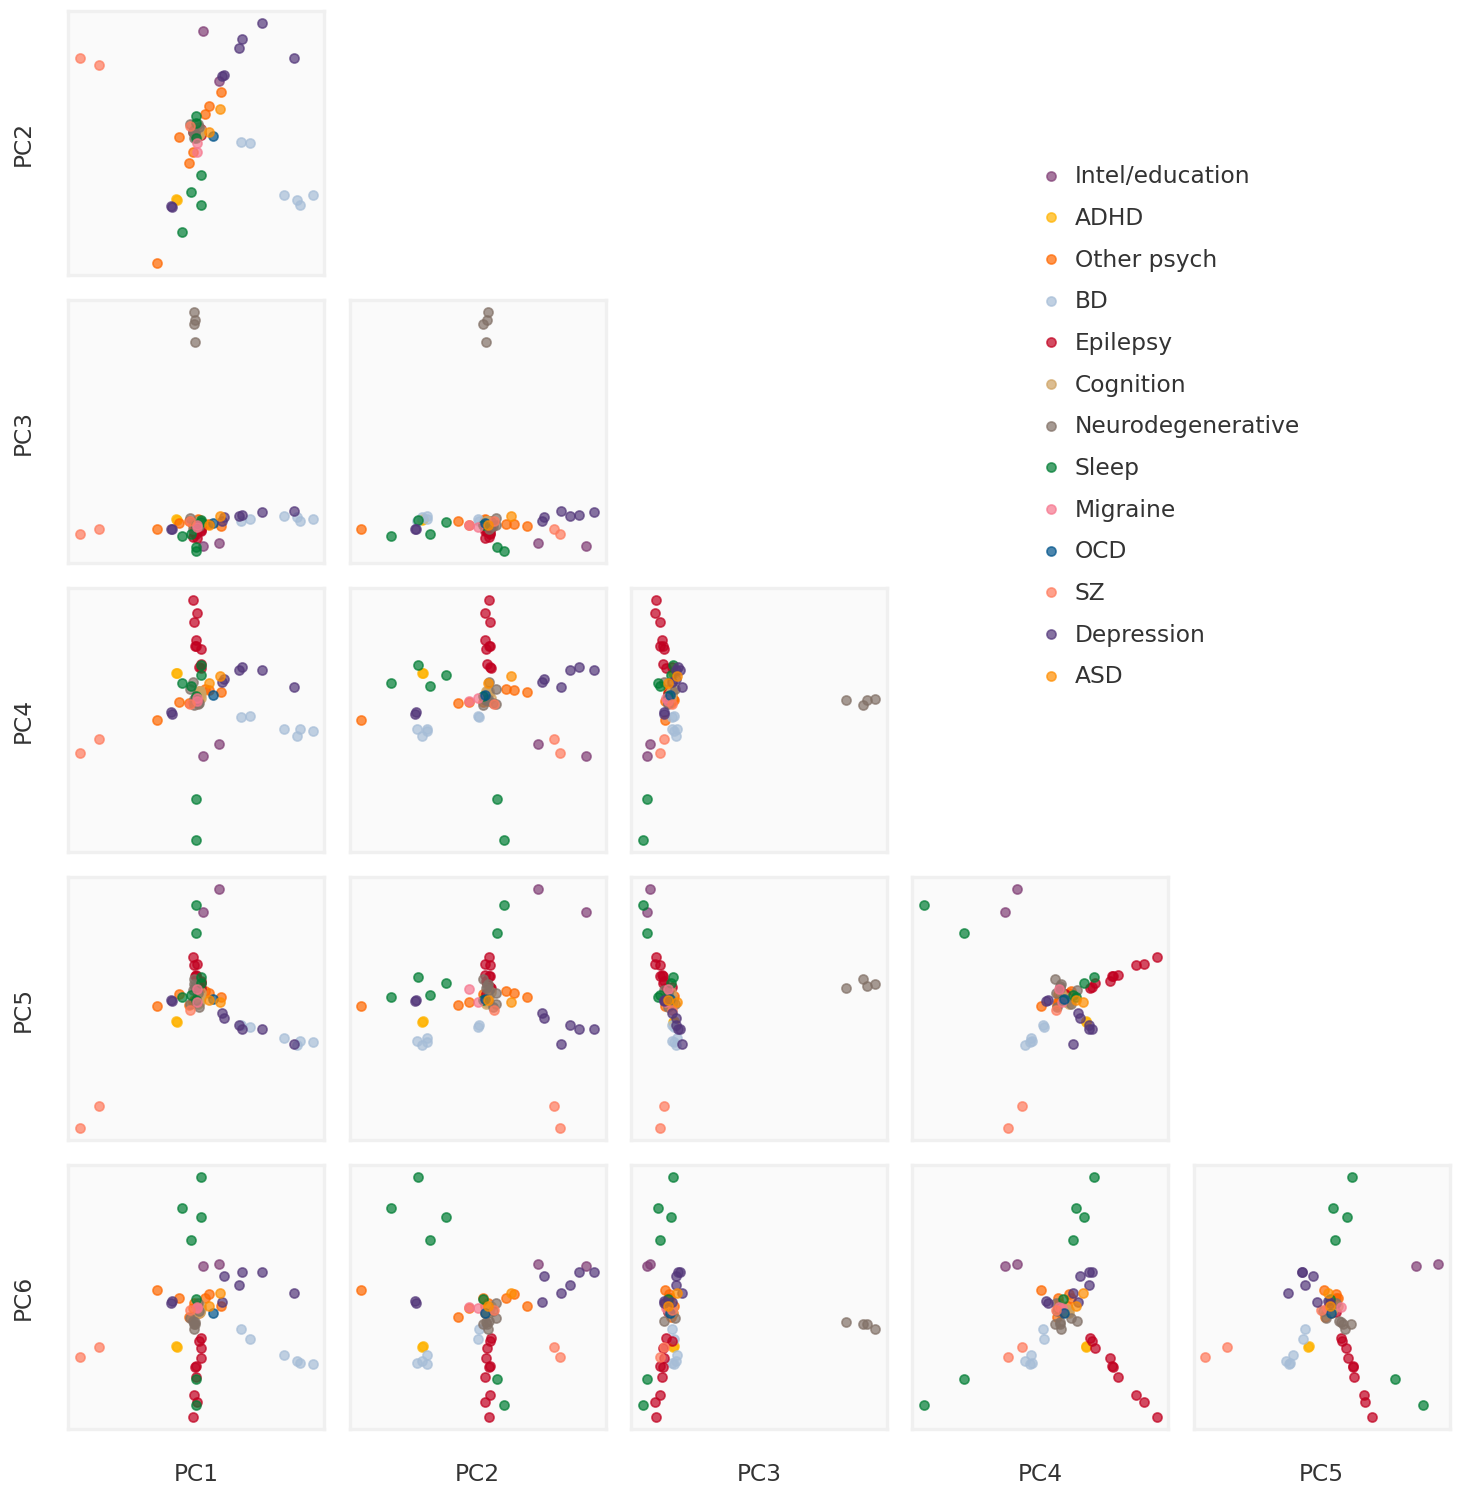

In [48]:
#| label: fig-multiple-pcs-low-rank-approx
#| fig-cap: "Comparison of the first 6 principal components of the low rank approximation"

plot_ncomp = 6
subplot_h = 2.0

nrow = plot_ncomp - 1
ncol = plot_ncomp - 1
figw = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
bgcolor = '#F0F0F0'


def make_plot_principal_components(ax, i, j, comp):
    pc1 = comp[:, j]
    pc2 = comp[:, i]
    for label in unique_labels:
        idx = np.array([k for k, x in enumerate(labels) if x == label])
        ax.scatter(pc1[idx], pc2[idx], s = 30, alpha = 0.7, label = label)
    return

fig = plt.figure(figsize = (figw, figh))
axmain = fig.add_subplot(111)

for i in range(1, nrow + 1):
    for j in range(ncol):
        ax = fig.add_subplot(nrow, ncol, ((i - 1) * ncol) + j + 1)
        
        ax.tick_params(bottom = False, top = False, left = False, right = False,
                       labelbottom = False, labeltop = False, labelleft = False, labelright = False)
        if j == 0: ax.set_ylabel(f"PC{i + 1}")
        if i == nrow: ax.set_xlabel(f"PC{j + 1}")
        if i > j:
            ax.patch.set_facecolor(bgcolor)
            ax.patch.set_alpha(0.3)
            make_plot_principal_components(ax, i, j, pca_cvopt)
            for side, border in ax.spines.items():
                border.set_color(bgcolor)
        else:
            ax.patch.set_alpha(0.)
            for side, border in ax.spines.items():
                border.set_visible(False)
                
        if i == 1 and j == 0:
            mhandles, mlabels = ax.get_legend_handles_labels()

axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.legend(handles = mhandles, labels = mlabels, loc = 'upper right', bbox_to_anchor = (0.9, 0.9))
          
        
plt.tight_layout()
plt.show()

In [52]:
train_error

{8.0: 1.0445314519131719,
 16.0: 1.041037978310444,
 32.0: 1.0342448061985816,
 64.0: 1.0212031961118844,
 128.0: 0.9980512728715728,
 256.0: 0.9592552598273123,
 512.0: 0.8958869142145245,
 1024.0: 0.7931029154998555,
 2048.0: 0.6284386790184624,
 4096.0: 0.3992465647184987,
 5000.0: 0.36700702863471724,
 6000.0: 0.37273215971181584,
 7000.0: 0.39743960536609935,
 8000.0: 0.46060258805130466}

In [53]:
test_error

{8.0: 0.7379283863527464,
 16.0: 0.7360553648577052,
 32.0: 0.7323992229046496,
 64.0: 0.7252923894633748,
 128.0: 0.7126499267407608,
 256.0: 0.6929325616806638,
 512.0: 0.6650417778754745,
 1024.0: 0.6294795062102471,
 2048.0: 0.5984243261174017,
 4096.0: 0.5813444546875715,
 5000.0: 0.5978681673912616,
 6000.0: 0.6282368213911593,
 7000.0: 0.6693131025636734,
 8000.0: 0.6992722149861493}